In [1]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from theano.tensor.nnet import conv2d
from theano.tensor.signal import downsample
from sklearn.utils import shuffle
from datetime import datetime
%matplotlib inline

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def get_transformed_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix().astype(np.float32)
    Y = data[:,0].astype('int')
    X = data[:,1:]/255.0
    return X,Y

In [3]:
def display_sample_image(X,Y):
    labels = ["0","1","2","3","4","5","6","7","8","9"]
    X, Y = shuffle(X,Y)
    for i in xrange(12):
        plt.subplot(3,4,i)
        img = X[i].reshape(28,28)
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(labels[Y[i]])
    plt.show()

In [4]:
X,Y = get_transformed_mnist_data()

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

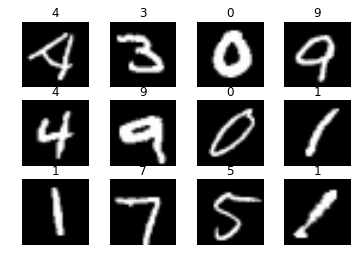

In [5]:
display_sample_image(X,Y)

In [6]:
def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1,M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)
def init_filter(shape,poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)
def error_rate(Y,T):
    return np.mean(Y!=T)
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,int(y[i])] = 1
    return y_ind
class HidenLayer(object):
    def __init__(self,M1,M2,an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1,M2)
        self.W = theano.shared(W,'W_%s' % self.id)
        self.b = theano.shared(b,'b_%s' % self.id)
        self.params = [self.W,self.b]
    def forward(self,X):
        return T.nnet.relu(X.dot(self.W) + self.b)
class ConvPoolLayer(object):
    def __init__(self,mi,mo,fw=5,fh=5,poolsz=(2,2)):
        sz = (mo,mi,fw,fh)
        W0 = init_filter(sz,poolsz)
        self.W = theano.shared(W0)
        b0 = np.zeros(mo,dtype=np.float32)
        self.b = theano.shared(b0)
        self.poolsz = poolsz
        self.params = [self.W,self.b]
    def forward(self,X):
        conv_out = conv2d(input=X,filters=self.W)
        pool_out = downsample.max_pool_2d(
            input=conv_out,
            ds=self.poolsz,
            ignore_border=True
        )
        return T.nnet.relu(pool_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [7]:
class CNN(object):
    def __init__(self,convpool_layer_sizes,hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
    def train(self, X, Y, lr=10e-7, mu=0.99, reg=10e-8, decay=0.99999, eps=10e-3, batch_sz=300, epochs=50, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        eps = np.float32(eps)
        
        #make validation set 
        X,Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        X,Y = X[:-1000], Y[:-1000]
        X_valid, Y_valid = X[-1000:], Y[-1000:]
        Y_ind = y2indicator(Y)
        Y_valid_ind = y2indicator(Y_valid)
        #initialize convpool layers 
        N,c, width, height = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo,fw,fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi,mo,fw,fh)
            self.convpool_layers.append(layer)
            outw = (outw - fw + 1) / 2
            outh = (outh - fh + 1) / 2
            mi = mo 
        #initialize the fully connected layers
        K = len(set(Y))
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HidenLayer(M1,M2,count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        # logistic regression layer 
        W, b = init_weight_and_bias(M1,K)
        self.W = theano.shared(W,'W_logreg')
        self.b = theano.shared(b,'b_logreg')
        
        # collect params for latter use 
        self.params = [self.W,self.b]
        for c in self.convpool_layers:
            self.params += c.params
        for h in self.hidden_layers:
            self.params + h.params
        # for momentum 
        dparams = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        cache = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        # setup theano functions and variables 
        th_X = T.tensor4('X',dtype='float32')
        th_Y = T.matrix('Y')
        P_Y = self.forward(th_X)
        rcost = T.sum([(p*p).sum() for p in self.params])
        cost = -(th_Y*T.log(P_Y)).sum() + rcost
        prediction = self.predict(th_X)
        cost_prediction_op = theano.function(
            inputs = [th_X,th_Y],
            outputs = [cost,prediction]
        )
        # updates 
        updates = [
            (p, p + mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ] + [
            (dp, mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ]
        train_op = theano.function(
            inputs = [th_X,th_Y],
            updates = updates
        )
        n_batches = N / batch_sz
        costs = []
        for i in xrange(epochs):
            for j in xrange(n_batches):
                X_batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Y_batch = Y_ind[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(X_batch,Y_batch)
                if j % 20 == 0:
                    c,p = cost_prediction_op(X_valid,Y_valid_ind)
                    costs.append(c)
                    e = error_rate(Y_valid,p)
                    print "i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e
        if show_fig:
            plt.plot(costs)
            plt.show()
    def forward(self,X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z = Z.flatten(ndim=2)
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)
    def predict(self,X):
        P_Y = self.forward(X)
        return T.argmax(P_Y,axis=1)

In [8]:
N = X.shape[0]
img = X.reshape(N,1,28,28)

i: 0 j: 0 nb: 136 cost: 2473.65812039 error rate: 0.911
i: 0 j: 20 nb: 136 cost: 2472.67011642 error rate: 0.911
i: 0 j: 40 nb: 136 cost: 2470.22118139 error rate: 0.911
i: 0 j: 60 nb: 136 cost: 2466.8213501 error rate: 0.909
i: 0 j: 80 nb: 136 cost: 2462.8223598 error rate: 0.888
i: 0 j: 100 nb: 136 cost: 2458.45216703 error rate: 0.86
i: 0 j: 120 nb: 136 cost: 2453.81736922 error rate: 0.828
i: 1 j: 0 nb: 136 cost: 2449.88417101 error rate: 0.797
i: 1 j: 20 nb: 136 cost: 2444.66779685 error rate: 0.735
i: 1 j: 40 nb: 136 cost: 2438.96424818 error rate: 0.663
i: 1 j: 60 nb: 136 cost: 2432.52097225 error rate: 0.621
i: 1 j: 80 nb: 136 cost: 2425.20793653 error rate: 0.59
i: 1 j: 100 nb: 136 cost: 2417.14475012 error rate: 0.581
i: 1 j: 120 nb: 136 cost: 2408.15121865 error rate: 0.583
i: 2 j: 0 nb: 136 cost: 2399.99108624 error rate: 0.572
i: 2 j: 20 nb: 136 cost: 2388.46441388 error rate: 0.552
i: 2 j: 40 nb: 136 cost: 2375.09641314 error rate: 0.537
i: 2 j: 60 nb: 136 cost: 2359.1491

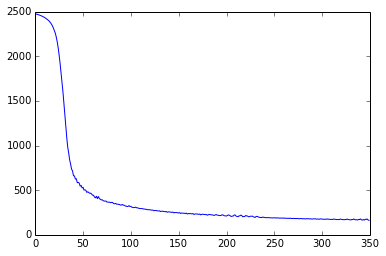

In [9]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (50, 3, 3),(100, 3, 3)],
    hidden_layer_sizes=[500, 300],
)
model.train(img,Y)

In [10]:
from six.moves import cPickle

In [17]:
f = open('mnist_cnn.ckpt', 'wb')
cPickle.dump(model, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

In [12]:
f = open("mnist_cnn.ckpt", 'rb')
mnist_model = cPickle.load(f)

In [13]:
img = X[100].reshape(1,1,28,28)

[]

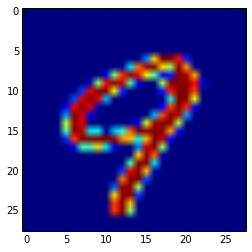

In [14]:
plt.imshow(img.reshape(28,28))
plt.plot()

In [15]:
a = mnist_model.predict(img)

In [16]:
a.eval()[0]

9